# BASEP Resume

## Imports

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spo

import pims
import pint

from tqdm import tqdm_notebook as prog_bar

import support as sp

idx = pd.IndexSlice
%matplotlib inline

%load_ext autoreload
%autoreload 2

# Index Set Up

The idea of index file is to have a document to easily identify which file contains the data of each experiment. 

In order to create the index file, we are going to define the date the experiments were taken. Then we are going to save the name of each file determining the relevant parameters to be taken into account (Number of particles, angular velocity of the traps, ring's radius, particle's relative length and potential landscape wavelength) and the file name with the tracking data of each experiment.

The index will be used then to obtain the values to calculate the current density curves.

In [2]:
directory = r"C:\Users\Eric\Documents\Projects\BASEP\Datasets\Test_u0_cte"#\tracking_files" #Insert here your directory
U0_cte_date = ["20190617","20190619"]

#U0_cte
tests = [np.linspace(20,61,42,dtype=int), np.linspace(3,12,10,dtype=int).tolist()+np.linspace(17,27,11,dtype=int).tolist()]

In [3]:
pre_list = sp.get_names(directory,ext = ".dat")

pre_list = pre_list[:]

files = []

i = 0
for date in U0_cte_date:        

    for test_number in tests[i]:

        file_name = "Tracking_Test{0}_".format(test_number)+date
        
        for file in pre_list:
            
            if file_name in file:
                files.append(file)
    
    i +=1 

In [4]:
#U0_cte_date Params
# As there are two dates in the not constant potential barrier data, we have to define a list with two positions with
# the tests performed to obtain the current density. So, one we have the test number of the test we want to collect,
# we have to define also the needed parameters to specify the test conditions.

Nparticles_12 = [27, 26, 23, 20, 17, 14, 11, 9, 6, 3, 1] 
Nparticles_3 = [33, 30, 25, 22, 18, 15, 11, 7, 4, 1]
Nparticles_4 = [40, 35, 30, 26, 22, 17, 13, 9, 5, 1]
Nparticles_5 = [30, 27, 24, 20, 17, 13, 10, 7, 3, 1]
Nparticles_6 = [30, 28, 25, 22, 19, 16, 13, 10, 6, 3, 1]

NparticlesInTests = [Nparticles_12, Nparticles_12, Nparticles_3, Nparticles_4, Nparticles_5, Nparticles_6]

sigma = [0.98, 0.9, 0.75, 0.62, 0.8, 0.85]

omega = [0.72, 0.66, 0.54, 0.46, 0.59, 0.63]

radius = [17.43, 19.0, 22.8, 27.47, 21.35, 20.07]

wavelength = [4.18, 4.37, 5.36, 6.59, 4.91, 4.62]

In [5]:
index = pd.DataFrame()

i = 0
j = 0

for s in sigma:
        
    for nparticles in NparticlesInTests[i]:
        
        pre_filename = files[j].split("\\")[-1].split("_")
        filename = pre_filename[1]+"_"+pre_filename[2]
        
        index = index.append({"N_particles": nparticles, "sigma": s, "omega": omega[i],
                             "radius": radius[i], "wavelength": wavelength[i], "Filename": filename},
                             ignore_index = True)
        
        j +=1
    
    i +=1

index = index.set_index(["sigma", "N_particles"])
index.head()

Filename  omega  radius  wavelength
sigma N_particles                                            
0.98  27.0         Test20_20190617   0.72   17.43        4.18
      26.0         Test21_20190617   0.72   17.43        4.18
      23.0         Test22_20190617   0.72   17.43        4.18
      20.0         Test23_20190617   0.72   17.43        4.18
      17.0         Test24_20190617   0.72   17.43        4.18

In [6]:
index.to_csv(directory+"\\"+"index.dat", sep="\t")

## Single Test Processing for Trajectory Analysis

Here it is going to be checked if the loading and processing of the files are correctly done. Also, the trajectories will be plot and commented. 

In [7]:
# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

mpl.rcParams.update({'figure.dpi': 200})

mpl.rcParams.update({'font.size': 10})

ureg = pint.UnitRegistry()
column = 18*ureg.cm

In [8]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spo

import pims
import pint

from tqdm import tqdm_notebook as prog_bar

import support as sp

idx = pd.IndexSlice
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
directory = r"C:\Users\Eric\Documents\Projects\BASEP\Datasets\Test_u0_cte"

In [10]:
index = pd.read_csv(directory+'\\'+"index.dat", sep="\t", index_col = [0,1])
index.head()

Filename  omega  radius  wavelength
sigma N_particles                                            
0.98  27.0         Test20_20190617   0.72   17.43        4.18
      26.0         Test21_20190617   0.72   17.43        4.18
      23.0         Test22_20190617   0.72   17.43        4.18
      20.0         Test23_20190617   0.72   17.43        4.18
      17.0         Test24_20190617   0.72   17.43        4.18

In [11]:
s = 0.62 #Desired particle size
p = 26 #Desired particle number

df = pd.DataFrame()

filename = index.loc[idx[s,p], "Filename"]
trackFilepath = directory+'\\Tracking_'+filename

tmstmp_list = sp.get_names(directory,ext = ".dat")

test_num = filename.split('_')[0]
test_date = filename.split('_')[-1][0:4]+'_'+trackFilepath.split('_')[-1][4:6]+'_'+trackFilepath.split('_')[-1][6:8]

tmsFilepath = sp.find_timestamp_file(test_num+'_'+test_date, tmstmp_list) 

Nparticles = p 
wavlen = index.loc[idx[s,p], "wavelength"] 
radius = index.loc[idx[s,p], "radius"] 
omega = index.loc[idx[s,p], "omega"] 

particleDens = Nparticles*4/(2*np.pi*radius) #4 is the particle diameter

trj = sp.trackingLoading(trackFilepath+'.dat') 
time = sp.tmstmpLoading(tmsFilepath+'.dat')

trj = sp.from_px_to_um(trj,0.1805)

trj = sp.add_time_to_trj(trj, time)

trj = sp.changeToPolarCoordinates(trj)

trj = sp.movementAnalyser(trj, omega)
trj["particle_density"] = particleDens

trj.head()

x          y  time          r     theta  theta_unwrap  \
frame particle                                                                  
0     0         -1.245689 -27.273797   0.0  27.302230 -1.616438     -1.616438   
      1         -1.440045  27.346112   0.0  27.384002  1.623408      1.623408   
      2         -7.164767  26.597087   0.0  27.545216  1.833932      1.833932   
      3         10.909446  25.103339   0.0  27.371402  1.160838      1.160838   
      4        -14.474107  23.364247   0.0  27.484319  2.125429      2.125429   

                theta_dot  theta_prime  theta_prime_unwrap  theta_dot_prime  \
frame particle                                                                
0     0               NaN     4.666747            4.666747              NaN   
      1               NaN     1.623408            1.623408              NaN   
      2               NaN     1.833932            1.833932              NaN   
      3               NaN     1.160838            1.160838              NaN   
      4               NaN     2.125429            2.125429              NaN   

                particle_density  
frame particle                    
0     0                 0.602552  
      1                 0.602552  
      2                 0.602552  
      3                 0.602552  
      4                 0.602552

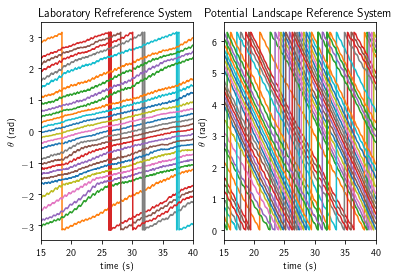

In [12]:
fig, ax = plt.subplots(1,2)

for part,trj_sub in trj.groupby("particle"):
    ax[0].plot(trj_sub.time,trj_sub.theta)
    ax[1].plot(trj_sub.time,trj_sub.theta_prime)
    
ax[0].set_xlim([15,40])
ax[0].set_title("Laboratory Refreference System")
ax[1].set_xlim([15,40])
ax[1].set_title("Potential Landscape Reference System")

ax[0].set_xlabel("time (s)")
ax[1].set_xlabel("time (s)")
ax[0].set_ylabel(r"$\theta$ (rad)")
ax[1].set_ylabel(r"$\theta$ (rad)")

plt.show()

# fig.savefig('Test45_20190426_Trajectories.png', 
#             pad_inches = 0,
#             bbox_inches = "tight")

In these trajectories we can clearly see how the particles advance inside the potential landscape in both reference systems.
When the particles follow the potntial landscape it can be seen a straigth line changing $\theta$ value in the laboratory reference system (LRS) and a constant $\theta$ value when looking to potential landscape reference system (PLRS).
The jumps between potential wells can be seen as constant $\theta$ in LRS. In PLRS can be seen when the trajectory change $\theta$ value. 

It can be seen a sudden change of position when the particle changes from 2$\pi$ to -2$\pi$ position. In order to see the trajectories without these jumps, the trajectories are unwraped and shown below. 

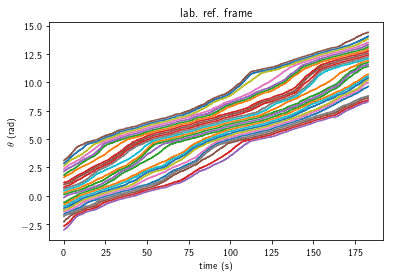

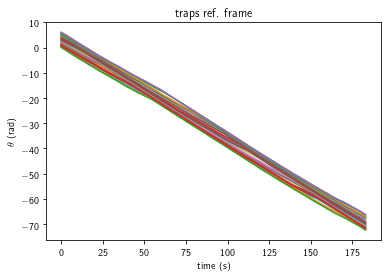

In [13]:
fig1, ax1 = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)

for part,trj_sub in trj.groupby("particle"):
    ax1.plot(trj_sub.time,trj_sub.theta_unwrap)
    ax2.plot(trj_sub.time,trj_sub.theta_prime_unwrap)
    

ax1.set_title("lab. ref. frame")
ax2.set_title("traps ref. frame")

ax1.set_xlabel("time (s)")
ax2.set_xlabel("time (s)")
ax1.set_ylabel(r"$\theta$ (rad)")
ax2.set_ylabel(r"$\theta$ (rad)");

# fig.savefig('Test19_20190619_Trajectories_unwrap.png', 
#             pad_inches = 0,
#             bbox_inches = "tight")

When the trajectories are unwrapped, it can be easily seen the whole picture of the trajectory.

In some cases where the particle density is high, it is possible to see density waves produced by the collisions among particles, which makes particles jump from one potential well to the next one triggering a domino effect.

C:\Users\Eric\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Eric\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


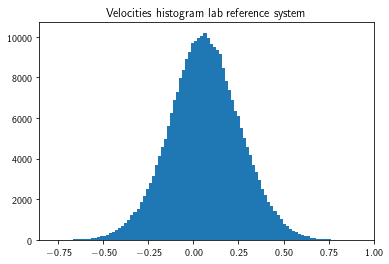

In [14]:
fig, ax = plt.subplots(1,1)

ax.hist(trj.loc[idx[:,:],"theta_dot"],100);

ax.set_title("Velocities histogram lab reference system");

# fig.savefig('Test19_20190619_velocities_hist.png', 
#             pad_inches = 0,
#             bbox_inches = "tight")

The velocities histogram typically would show two main trends, corresponding to the velocity of the particles when are stucked to the landscape wells and the relative velocity they have when jumping from one well to the next one.

Nevertheless, it has been also observed in some cases it is only one trend. This behaviour occurs when the particles are continously hopping among potential wells.

### Multi File Reading for Trajectories pre-processing

In order to reduce the number of files implied in the trajectory analysis, we are going to make a data preprocess to condense in a single file trajectories and timestamp.

The next cell reads index file, makes the trajectory process to all the files and saves them in a directory containing only the preprocessed trajectory files.

In [15]:
s = 0.98
p = 27

for s in prog_bar(index.index.get_level_values("sigma").unique().to_list()):

    for p in index.loc[idx[s,:],:].index.get_level_values("N_particles").unique().to_list():

        filename = index.loc[idx[s,p], "Filename"]
        trackFilepath = directory+'\\Tracking_'+filename

        tmstmp_list = sp.get_names(directory,ext = ".dat")

        test_num = filename.split('_')[0]
        date = filename.split('_')[-1]
        test_date = date[0:4]+'_'+date[4:6]+'_'+date[6:8] # Send tese lines to support file?
        
        tmsFilepath = sp.find_timestamp_file(test_num+'_'+test_date, tmstmp_list)

        Nparticles = p
        wavlen = index.loc[idx[s,p], "wavelength"]
        radius = index.loc[idx[s,p], "radius"]
        omega = index.loc[idx[s,p], "omega"]

        particleDens = Nparticles*4/(2*np.pi*radius) #4 is the particle diameter

        trj = sp.trackingLoading(trackFilepath+'.dat') 
        time = sp.tmstmpLoading(tmsFilepath+'.dat')

        trj = sp.from_px_to_um(trj,0.1805)

        trj = sp.add_time_to_trj(trj, time)
        
        trj = sp.changeToPolarCoordinates(trj)
        
        trj.to_csv(directory+'\\Trajectories\\Trajectory_'+filename.split("_")[0]+"_"+filename.split("_")[1]+".dat", sep = "\t")

KeyboardInterrupt: 

# Current Density Data

In this section we are going to obtain the relevant data to make the plot of the current density from the Index file information.

As the Index file contains the information of the tracking files and the relevant parameters for the current density calculation, we are going to load it and use the support file to build a DataFrame, and hence a file, containing:

- Particle's relative size
- Particle density
- Particle's position
- Velocity of particles
- Current Density Value
- Timestamp

The data saved will be for both lab and experiment reference systems.

## Trajectory File Processing and Current Density Parameters Obtainment

Once checked the correct behaviour of the algoritm in analysing the data, the process is generalised to process the batch of tracking files. From here, we are going to obtain the DataFrame with the necessary data (specified above) to plot the fundamental diagram (current density vs. particle density).

In [ ]:
directory = r"C:\Users\Eric\Documents\Projects\BASEP\Datasets\Test_u0_cte"

In [ ]:
index = pd.read_csv(directory+'\\'+"index.dat", sep="\t", index_col = [0,1])
index.head()

In [ ]:
#directory = r"Z:\BASEP\Datasets\Test_u0_cte\Trajectories" #Insert here your directory

df = pd.DataFrame()

for s in prog_bar(index.index.get_level_values("sigma").unique().to_list()):

    for p in index.loc[idx[s,:],:].index.get_level_values("N_particles").unique().to_list():
        
        trj_path = directory+r'\Trajectories\Trajectory_'+index.loc[idx[s,p], "Filename"]

        Nparticles = p
        wavlen = index.loc[idx[s,p], "wavelength"]
        radius = index.loc[idx[s,p], "radius"]
        omega = index.loc[idx[s,p], "omega"]
        particleDens = Nparticles*4/(2*np.pi*radius) #4 is the particle diameter

        trj = sp.trjLoading(trj_path+".dat")
        #trj = sp.from_px_to_um(trj,0.1805) Included in trajectory (x and y values given in microns)
        trj = sp.movementAnalyser(trj, omega)
        trj["particle_density"] = particleDens

        df = df.append({'sigma': s, 'p_density': particleDens,
                        'exp_currentDens': trj.theta_dot_prime.mean()*particleDens,
                        'lab_currentDens': trj.theta_dot.mean()*particleDens,
                        'exp_particle_vel': trj.theta_dot_prime.mean(),
                        'lab_particle_vel': trj.theta_dot.mean(),
                        'radius': radius, 'omega': omega, 'lambda': wavlen, 'N_particles': Nparticles}, ignore_index=True)

df = df.set_index(['sigma', 'p_density'], drop=True)
df.head()

In [ ]:
df.to_csv(directory+"\\"+"Current_Density_curves.dat", sep = "\t")

# Fundamental Diagram

Finally, with all the data collected above, we are able to make the plots we need in this section

In [16]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spo

import pims
import pint

from tqdm import tqdm_notebook as prog_bar

import support as sp

idx = pd.IndexSlice
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#Insert here your directory
directory = r"C:\Users\Eric\Documents\Projects\BASEP\Datasets\Test_u0_cte"

df = pd.read_csv(directory+'\\'+"Current_Density_curves.dat", sep="\t", index_col = [0,1])
df.head()

N_particles  exp_currentDens  exp_particle_vel  \
sigma p_density                                                   
0.98  0.986158          27.0         0.000963          0.000976   
      0.949634          26.0         0.000206          0.000217   
      0.840061          23.0        -0.002762         -0.003288   
      0.730487          20.0        -0.008212         -0.011242   
      0.620914          17.0        -0.022352         -0.035999   

                 lab_currentDens  lab_particle_vel  lambda  omega  radius  
sigma p_density                                                            
0.98  0.986158          0.710996          0.720976    4.18   0.72   17.43  
      0.949634          0.683943          0.720217    4.18   0.72   17.43  
      0.840061          0.602081          0.716712    4.18   0.72   17.43  
      0.730487          0.517739          0.708758    4.18   0.72   17.43  
      0.620914          0.424706          0.684001    4.18   0.72   17.43

In [18]:
# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

mpl.rcParams.update({'figure.dpi': 200})

mpl.rcParams.update({'font.size': 10})

ureg = pint.UnitRegistry()
column = 18*ureg.cm

In [20]:
df.head()

N_particles  exp_currentDens  exp_particle_vel  \
sigma p_density                                                   
0.98  0.986158          27.0         0.000963          0.000976   
      0.949634          26.0         0.000206          0.000217   
      0.840061          23.0        -0.002762         -0.003288   
      0.730487          20.0        -0.008212         -0.011242   
      0.620914          17.0        -0.022352         -0.035999   

                 lab_currentDens  lab_particle_vel  lambda  omega  radius  
sigma p_density                                                            
0.98  0.986158          0.710996          0.720976    4.18   0.72   17.43  
      0.949634          0.683943          0.720217    4.18   0.72   17.43  
      0.840061          0.602081          0.716712    4.18   0.72   17.43  
      0.730487          0.517739          0.708758    4.18   0.72   17.43  
      0.620914          0.424706          0.684001    4.18   0.72   17.43

Text(0.5, 0.98, 'External Reference System')

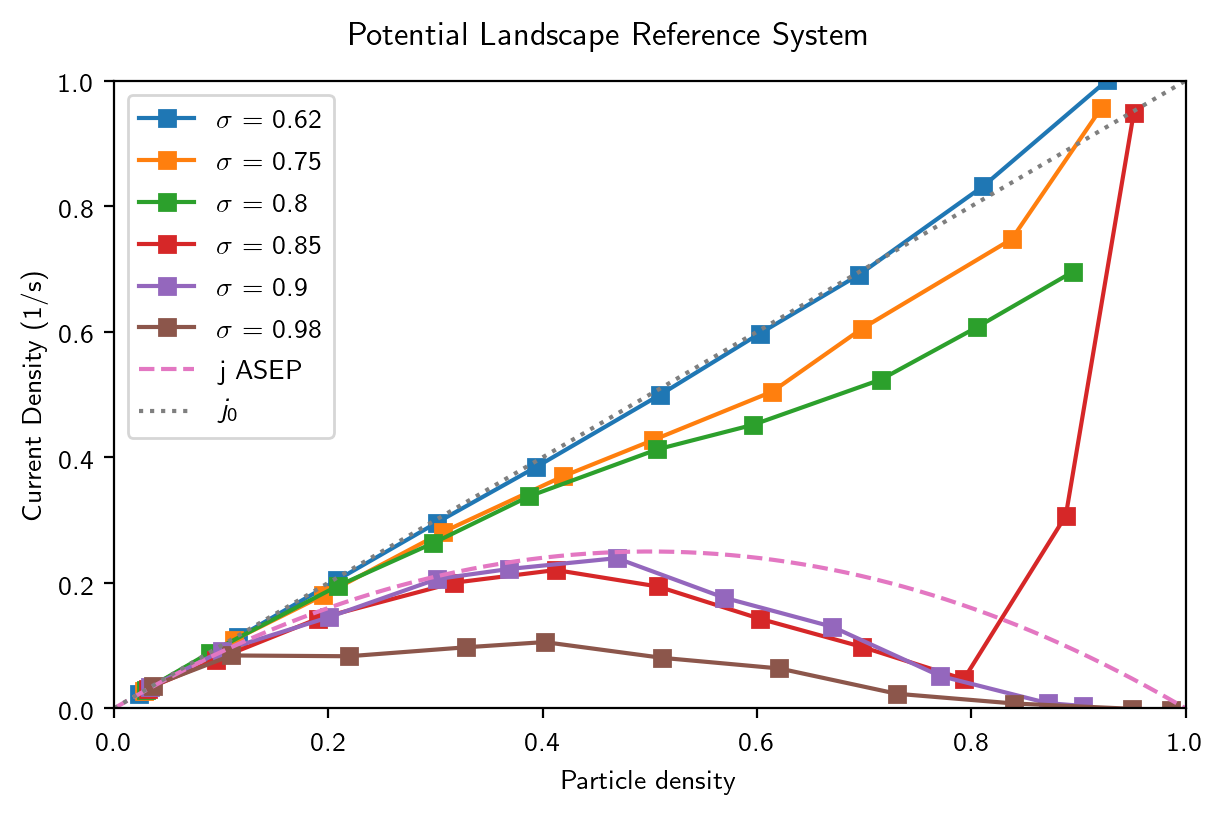

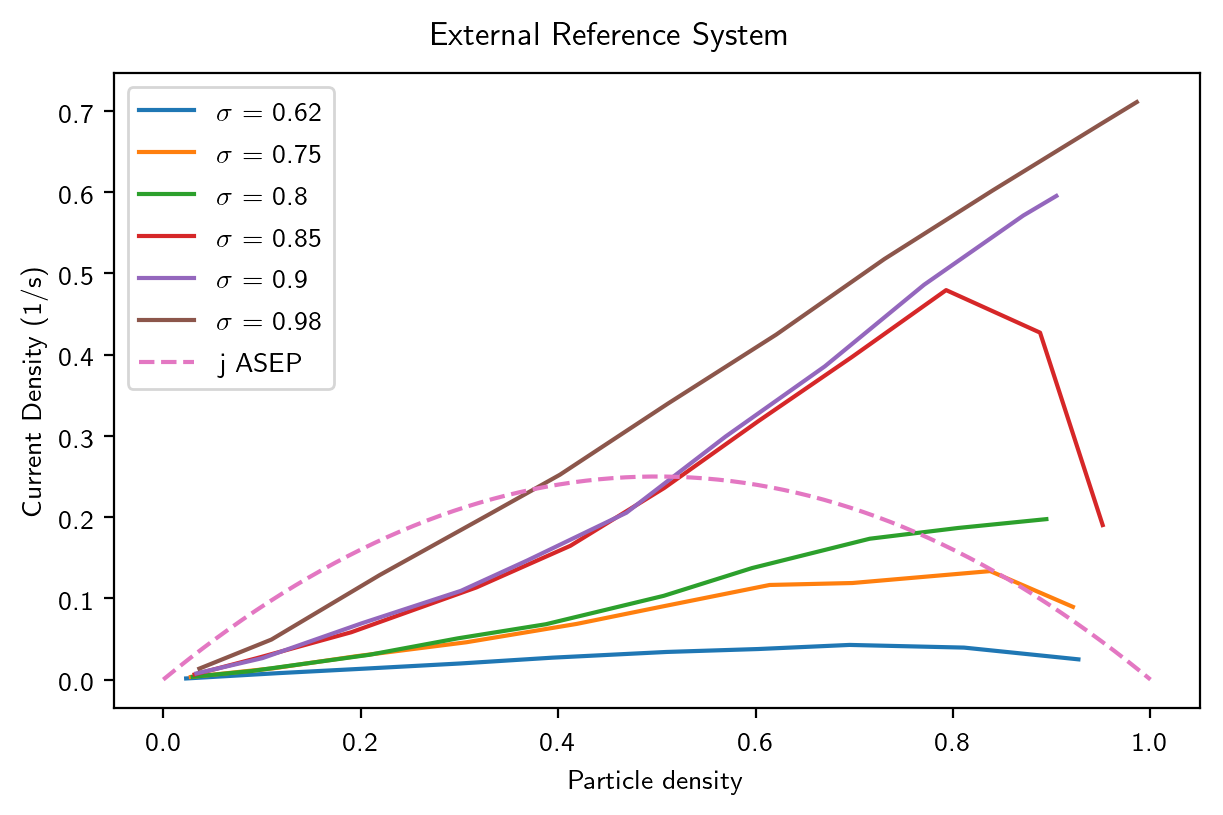

In [21]:
f1, ax1 = plt.subplots(1,1,constrained_layout=True)#,figsize=(10,5))
f2, ax2 = plt.subplots(1,1,constrained_layout=True)#,figsize=(10,5))

single_part_vel = []
lab_single_part_vel = []

for s, df_sub in prog_bar(df.groupby('sigma')):

    tag = "$\sigma$ = {}".format(s)

    last_particle_vel = df_sub[df_sub.N_particles.values == 1].exp_particle_vel.values[0]
    single_part_vel.append(last_particle_vel)

    last_particle_vel_lab = df_sub[df_sub.N_particles.values == 1].lab_particle_vel.values[0]
    lab_single_part_vel.append(last_particle_vel_lab)

    x = df_sub.index.get_level_values("p_density").unique().to_list()
    
    ax1.plot(x, df_sub.exp_currentDens.values/last_particle_vel, label=tag, marker='s')

    ax2.plot(x, df_sub.lab_currentDens.values, label=tag)

pd_ASEP = np.linspace(0, 1, 300)
mean_ASEP = -np.mean(single_part_vel)*pd_ASEP*(1-pd_ASEP)/-np.mean(single_part_vel)
ax1.plot(pd_ASEP, mean_ASEP, '--', label="j ASEP")

mean_ASEP_lab = -np.mean(lab_single_part_vel)*pd_ASEP*(1-pd_ASEP)/-np.mean(lab_single_part_vel)
ax2.plot(pd_ASEP, mean_ASEP_lab, '--', label="j ASEP")

currDens_0 = np.mean(single_part_vel)*pd_ASEP/np.mean(single_part_vel)
ax1.plot(pd_ASEP, currDens_0, ':',label='$j_0$')

ax1.set_xlabel("Particle density ")
ax1.set_ylabel("Current Density (1/s)")
ax1.set_ylim([0,1])
ax1.set_xlim([0,1])
ax1.legend()


ax2.set_xlabel("Particle density ")
ax2.set_ylabel("Current Density (1/s)")
ax2.legend()


f1.suptitle("Potential Landscape Reference System")
f2.suptitle("External Reference System")

# f1.savefig(directory+"\\"+'Fundamental_Diagram.png', 
#             pad_inches = 0,
#             bbox_inches = "tight")

When looking at the fundamental diagram obtained from the laboratory reference system, we see that the consistence with behavior depicted in the theoretical simmulations.

For large relative particles size it is seen a decrease in the current density, while for small particle size the current is increased with the particle density.
Also, it can be seen the ASEP behaviour for specific particle size.

Nevertheless, the behaviour of the current density change dramatically in a very narrow window of the particle size (between $\sigma$ = 0.8 and $\sigma$ = 0.85).

The curves change substancially when changing the potential barrier height.

# Obtention of particle velocity in $\mu$m/s

The aim of obtaining particles' velocity in $\mu$m/s is to compare with velocities reported by Roichman (PRE 90, 042302 2014 and PRL 107, 158302 2001) where the hydrodynamic interactions are studied.
The key point is to see if we have similar velocity regimes. If we have, we will possibly have hydrodynamic interactions in our experiments, otherwise we will have to determine the presence (or not) of hydrodynamic interactions by other means.

The velocities reported are in the range of ~10 to 90 $\mu$m/s for 1 particle and from 45 to 135 $\mu$m/s for 21 particles.

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spo

import pims
import pint

from tqdm import tqdm_notebook as prog_bar

import support as sp

idx = pd.IndexSlice
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
#Insert here your directory
directory = r"C:\Users\Eric\Documents\Projects\BASEP\Datasets\Test_u0_cte"

df = pd.read_csv(directory+'\\'+"Current_Density_curves.dat", sep="\t", index_col = [0,1])
df.head()

In [ ]:
velocities = []

for s, trj_sub in df.groupby("sigma"):
    print(s)
    velocities.append(df.loc[idx[s,:],"lab_particle_vel"][df.N_particles == 1].mean()*df.loc[idx[s,:],"radius"][df.N_particles == 1].mean())
    
velocities

In [ ]:
velocities = []

for s, trj_sub in df.groupby("sigma"):
    print(s)
    velocities.append(df.loc[idx[s,:],"lab_particle_vel"][df.N_particles == 20].mean()*df.loc[idx[s,:],"radius"][df.N_particles == 20].mean())
    
velocities

In [ ]:
velocities = []

for s, trj_sub in df.groupby("sigma"):
    print(s)
    velocities.append(df.loc[idx[s,:],"lab_particle_vel"][df.N_particles == 22].mean()*df.loc[idx[s,:],"radius"][df.N_particles == 22].mean())
    
velocities

As we have the velocities' values in rad/s we change to $\mu$m/s by multiplicating the value by the radius of the ring, so we obtain the arc distance traveleed by the particle in 1 second.

What it has been done is to obtain the velocity of a single, 20 and 22 particles (as we don't have velocity values for 21 particles) for the different ring radius.
For single particle, velocity values are in the range from 1.6 to 6.4 $\mu$m/s; for 20 and 22 particles in the system we see velocities from 1.8 to 12.4 $\mu$m/s.
The velocities in our system are far away from that of Roichman (~10 to 90 $\mu$m/s for 1 particle and from 45 to 135 $\mu$m/s for 21 particles), so we will have to determine the presence of hydrodynamic interactions in another way.